In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import os
import logging
import pandas as pd
import os.path as op
from PIL import Image, ImageOps
from pathlib import Path

from keras.models import load_model
from keras.utils import to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adadelta, SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
from matplotlib import pyplot as plt

import numpy as np

print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.
/home/EFeel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/EFeel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/EFeel/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/EFeel/anaconda3/lib/python3.7/site-packages/tensorflo

['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Data properties
num_classes = 10
img_x, img_y = 128, 128

In [3]:
def load_train():
    train_images = pd.read_pickle('train_max_x')
    train_labels = pd.read_csv('train_max_y.csv').to_numpy()[:, 1]
    return train_images, train_labels

def load_test():
    return pd.read_pickle('test_max_x')

def predictions_to_csv(pred, filename):
#     if not op.isdir(RESULT_DIR):
#         os.makedirs(RESULT_DIR)
    res = pd.Series(pred, name='Label')
    submission = pd.concat([pd.Series(range(0, res.shape[0]), name='Id'), res], axis=1)
    submission.to_csv(filename, index=False)

In [4]:
# Load training data
train_images, train_labels = load_train()
x_train, x_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [5]:
# Reshape and normalize images
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_valid = x_valid.reshape(x_valid.shape[0], img_x, img_y, 1)
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255.
x_valid /= 255.

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)

print(f'Train images dim: {x_train.shape}')
print(f'Train labels dim:{y_train.shape}')
print(f'Validation images dim: {x_valid.shape}')
print(f'Validation labels dim:{y_valid.shape}')

Train images dim: (40000, 128, 128, 1)
Train labels dim:(40000, 10)
Validation images dim: (10000, 128, 128, 1)
Validation labels dim:(10000, 10)


In [6]:
class VGG():
    def __init__(self, input_shape, num_classes, optimizer):
        self.model = Sequential()
        #layer1
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        
        #layer2
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        #layer3
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        #fully connected layer
        self.model.add(Flatten())
        self.model.add(Dense(1024, activation='relu'))
        self.model.add(Dense(1024, activation='relu'))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(num_classes, activation='softmax'))

        self.model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
        print(self.model.summary())

    def train(self, x, y, x_valid, y_valid, batch_size=64, epochs=60, datagen=True, num_steps='auto', callbacks=None):
        if num_steps == 'auto':
            num_steps = x.shape[0] // batch_size
        if datagen:
            data_generator = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=1,
                zoom_range=0.1
            )
            self.history = self.model.fit_generator(
                data_generator.flow(x, y, batch_size=batch_size),
                steps_per_epoch=num_steps,
                epochs=epochs,
                verbose=1,
                validation_data=(x_valid, y_valid),
                callbacks=callbacks
            )
        else:
            self.history = self.model.fit(
                x, y,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_valid, y_valid),
                callbacks=callbacks
            )
        return self.history

    def evaluate(self, x, y):
        return self.model.evaluate(x, y, verbose=0)

    def predict(self, x):
        return self.model.predict(x)

    def save(self, filename):
        self.model.save(filename)

In [7]:
# optimizer = Adadelta()
optimizer = Adam()
#optimizer = SGD()
# optimizer = Nadam()

# Train params
batch_size = 64
num_steps = 'auto'
# num_steps = 1000
epochs = 100
model_name = 'VGG9_2'

In [8]:
# Callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.85)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = ModelCheckpoint(
    filepath=f'./trained_models/{model_name}_best.h5',
    verbose=1,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    period=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 60, 32)      

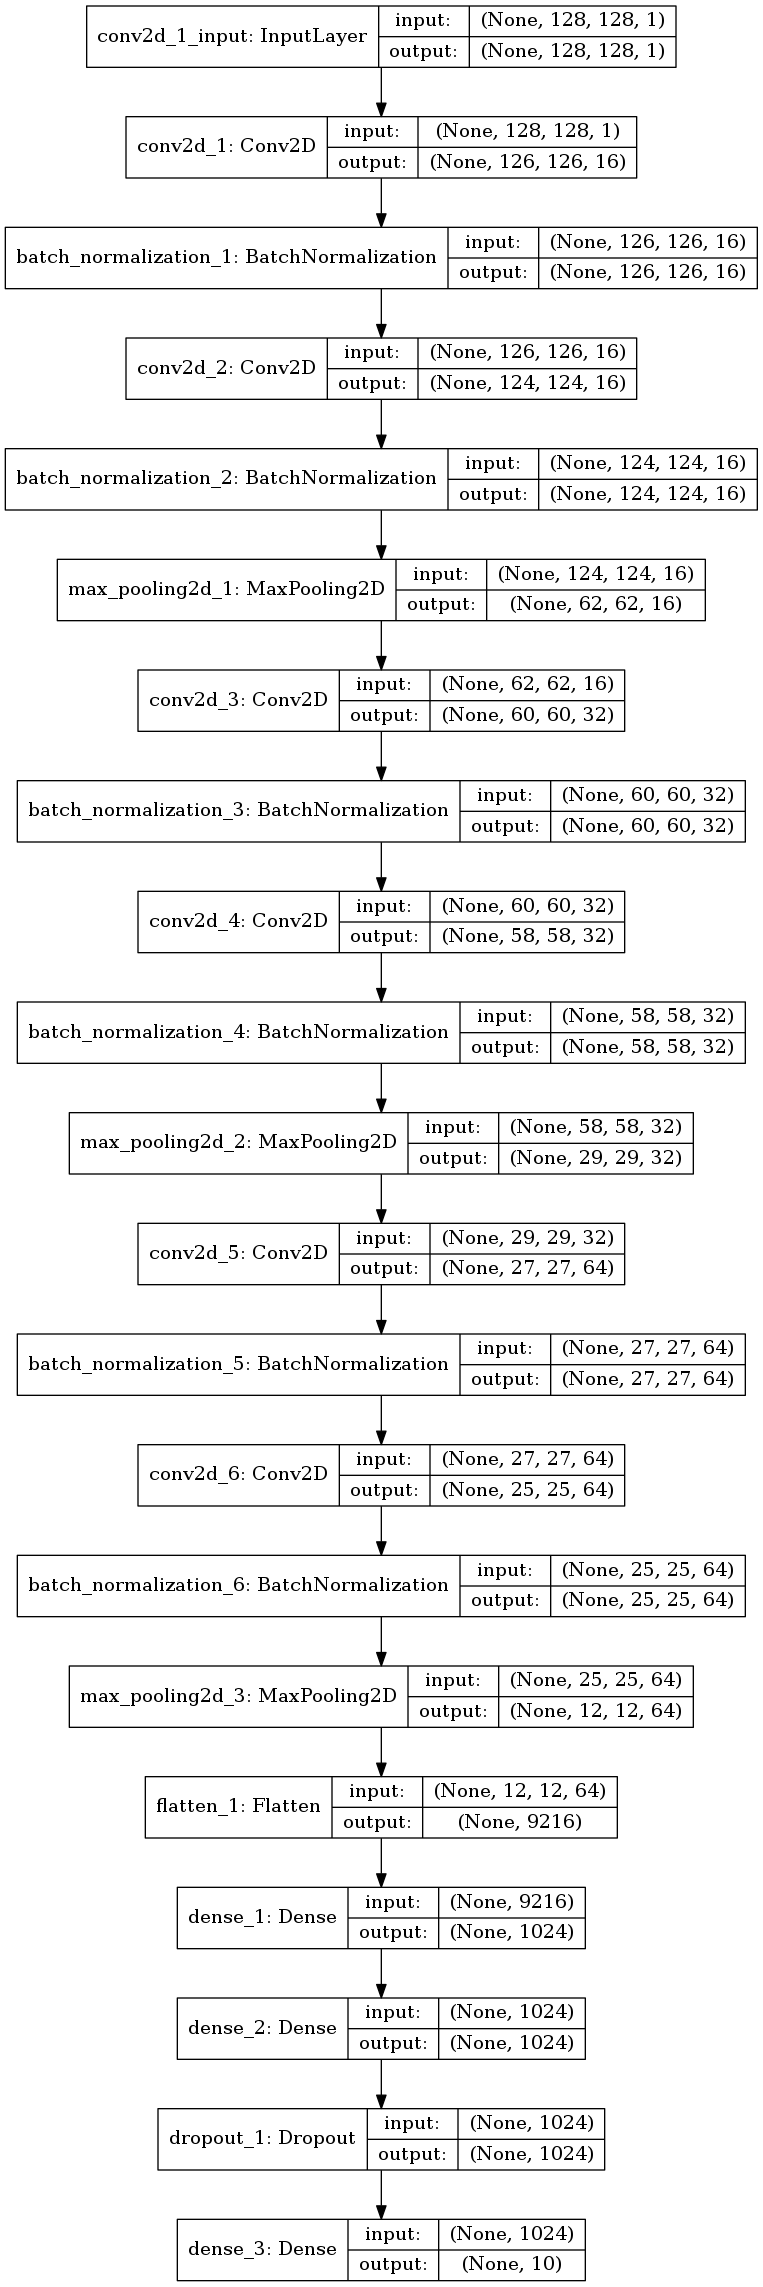

In [9]:
model = VGG(input_shape=(img_x, img_y, 1), num_classes=num_classes, optimizer=optimizer)
plot_model(model.model, to_file='{model_name}_arch.png', show_shapes=True)

In [10]:
history = model.train(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=batch_size,
    epochs=epochs,
    datagen=True,
    num_steps=num_steps,
    callbacks=[annealer, early_stop, checkpoint]
    )


Epoch 1/100
625/625 [==============================] - 49s 79ms/step - loss: 2.1211 - accuracy: 0.2413 - val_loss: 1.8967 - val_accuracy: 0.2689

Epoch 00001: val_accuracy improved from -inf to 0.26890, saving model to ./trained_models/VGG9_2_best.h5
Epoch 2/100
625/625 [==============================] - 46s 74ms/step - loss: 1.8782 - accuracy: 0.2718 - val_loss: 2.0948 - val_accuracy: 0.2315

Epoch 00002: val_accuracy did not improve from 0.26890
Epoch 3/100
625/625 [==============================] - 46s 73ms/step - loss: 1.5656 - accuracy: 0.3879 - val_loss: 1.5483 - val_accuracy: 0.3544

Epoch 00003: val_accuracy improved from 0.26890 to 0.35440, saving model to ./trained_models/VGG9_2_best.h5
Epoch 4/100
625/625 [==============================] - 45s 72ms/step - loss: 1.0941 - accuracy: 0.6248 - val_loss: 0.7906 - val_accuracy: 0.7342

Epoch 00004: val_accuracy improved from 0.35440 to 0.73420, saving model to ./trained_models/VGG9_2_best.h5
Epoch 5/100
625/625 [==================


Epoch 00034: val_accuracy improved from 0.95540 to 0.95710, saving model to ./trained_models/VGG9_2_best.h5
Epoch 35/100
625/625 [==============================] - 47s 75ms/step - loss: 0.2277 - accuracy: 0.9262 - val_loss: 0.1718 - val_accuracy: 0.9573

Epoch 00035: val_accuracy improved from 0.95710 to 0.95730, saving model to ./trained_models/VGG9_2_best.h5
Epoch 36/100
625/625 [==============================] - 47s 75ms/step - loss: 0.2230 - accuracy: 0.9305 - val_loss: 0.2039 - val_accuracy: 0.9591

Epoch 00036: val_accuracy improved from 0.95730 to 0.95910, saving model to ./trained_models/VGG9_2_best.h5
Epoch 37/100
625/625 [==============================] - 47s 75ms/step - loss: 0.2249 - accuracy: 0.9302 - val_loss: 0.2585 - val_accuracy: 0.9417

Epoch 00037: val_accuracy did not improve from 0.95910
Epoch 38/100
625/625 [==============================] - 46s 74ms/step - loss: 0.2182 - accuracy: 0.9313 - val_loss: 0.1869 - val_accuracy: 0.9600

Epoch 00038: val_accuracy improv

In [11]:
model = load_model(f'./trained_models/{model_name}_best.h5')
score = model.evaluate(x_valid, y_valid)

10000/10000 [==============================] - 4s 404us/step


In [12]:
print(f'Validation Loss: {score[0]}')
print(f'Validation Accuracy: {score[1]}')

Validation Loss: 0.14837929077371956
Validation Accuracy: 0.9696999788284302


In [13]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

if score[1] >= 0.97:
    model.save(f'./trained_models/{model_name}_{round(score[1]*100, 2)}%.h5')
else:
    print('Model did not exceed baseline validation accuracy, not saving.')


Model did not exceed baseline validation accuracy, not saving.


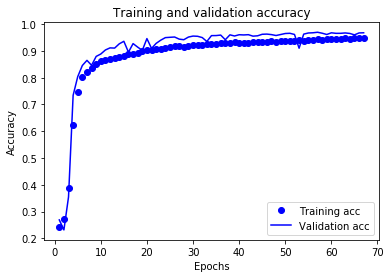

In [14]:
epcs = range(1, len(acc) + 1)
plt.plot(epcs, acc, 'bo', label='Training acc')
plt.plot(epcs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'./figures/{model_name}_{round(score[1]*100, 2)}%.png')
plt.show()

In [15]:
x_test = load_test()
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
x_test = x_test.astype('float32')
x_test /= 255.
print('Test dim: ', x_test.shape)

Test dim:  (10000, 128, 128, 1)


In [16]:
# Generate test labels
import numpy as np
y_test = model.predict(x_test)
y_test = np.argmax(y_test, axis=1)
print(y_test.shape)
predictions_to_csv(y_test, f'{model_name}_pred.csv')

(10000,)


In [17]:
model.save(f'./trained_models/{model_name}_{round(score[1]*100, 2)}%.h5')